In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import sys

import anndata

import networkx as nx
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import receptor_ligand_helpers as rl
import pseudobulk_helpers
import plotting_helpers as ph

In [3]:
all_cells_adata = sc.read_h5ad("../analysis_objects/all_grans_nodubs.h5ad")


In [5]:
receptor_ligand_list = pd.read_csv("interactions_analysis_reference/ligand_receptors.csv") 
print(receptor_ligand_list.shape)
receptor_ligand_list = rl.reduce_receptor_ligand_list(receptor_ligand_list,all_cells_adata.raw.var_names)
print(receptor_ligand_list.shape)

(2570, 2)
(2243, 2)


In [6]:
all_cells_adata.obs["Subclusters_t"] = all_cells_adata.obs["Subclusters"]
all_cells_adata.obs["Subclusters_t"] = all_cells_adata.obs["Subclusters_t"].astype(str)
all_cells_adata.obs.loc[all_cells_adata.obs["General Celltypes"]=="Macrophages/Monocytes","Subclusters_t"]="Macrophages/Monocytes"
celltype_col = "Subclusters_t"
new_adata = anndata.AnnData(all_cells_adata.raw.X,obs=all_cells_adata.obs)
new_adata.var_names=all_cells_adata.raw.var_names
new_adata.obs_names=all_cells_adata.obs_names
per_sample_celltype_exp = pseudobulk_helpers.save_pseudobulk_counts(new_adata, new_adata.obs,celltype_col=celltype_col, sample_col="sample")
general_meta = pseudobulk_helpers.save_metadata_for_pseudobulk_deseq(new_adata.obs[[celltype_col,"treatment","M.Number","sample"]], celltype_col=celltype_col,cell_counts=True)




/data/cb/scratch/nyquist/deeper_sequencing_analysis/figure_making_plots.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_metadata[grp_name] = [processed_metadata.loc[i,celltype_col]+"_"+processed_metadata.loc[i,sample_col] for i in processed_metadata.index]
/data/cb/scratch/nyquist/deeper_sequencing_analysis/figure_making_plots.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_metadata[c] = processed_metadata[c].astype(str)


In [ ]:
def receptor_ligand_numpy(receptor_ligand_list,celltypes_list,one_gran_per_celltype_exp, pcts_celltypes, pcts_totals_ligand_numpy,pcts_totals_receptor_numpy):
    ligand_numpy_matrix = one_gran_per_celltype_exp.loc[celltypes_list, receptor_ligand_list["Ligand"]].to_numpy()
    receptor_numpy_matrix = one_gran_per_celltype_exp.loc[celltypes_list, receptor_ligand_list["Receptor"]].to_numpy()
    pcts_celltypes_ligand_numpy = pcts_celltypes.loc[celltypes_list,receptor_ligand_list["Ligand"]].to_numpy()
    pcts_celltypes_receptor_numpy = pcts_celltypes.loc[celltypes_list,receptor_ligand_list["Receptor"]].to_numpy()

    expression_scores = np.einsum('ik,jk->ijk',ligand_numpy_matrix,receptor_numpy_matrix)

    pcts_senders = pcts_celltypes_ligand_numpy/pcts_totals_ligand_numpy
    pcts_receivers = pcts_celltypes_receptor_numpy/pcts_totals_receptor_numpy
    scaling = np.einsum('ik,jk->ijk', pcts_senders,pcts_receivers)
    scaled_matrix = expression_scores*scaling
    
    return scaled_matrix
def _one_gran_raw_scores_and_pvalues(celltype_col,n_perm,gran,receptor_ligand_list):
    ## new_adata is a global variable because it is too big to serialize!
    # so you can't put this function in another file
    
    this_gran_results_dict = {}
    
    #this_gran_results_dict["scores"] = _one_gran_raw_scores(per_sample_celltype_exp, general_meta, celltype_col,n_perm,gran,receptor_ligand_list,this_grand_results_dict)
    #print(per_gran_results)
    ## If you further parallelize, split into batches here, not during the for loop
    this_gran_adata = new_adata[new_adata.obs["sample"]==gran]
    celltypes = this_gran_adata.obs[celltype_col].values
    celltypes_list = list(set(celltypes))
    #print(celltypes_list)
    all_receptor_ligands = list(set(receptor_ligand_list["Receptor"].values).union(set(receptor_ligand_list["Ligand"].values)))
    this_gran_exp = pd.DataFrame(this_gran_adata.X, columns=this_gran_adata.var_names)[all_receptor_ligands]
    this_gran_expressing = this_gran_exp > 0 # this is to get the number of cells expressing each gene
    this_gran_all_pcts = this_gran_expressing.sum(axis=0) # this sums the number of cells expressing each gene in the full gran
    pcts_totals_ligand_numpy = this_gran_adata.n_obs#this_gran_all_pcts[receptor_ligand_list["Ligand"]].to_numpy()
    pcts_totals_receptor_numpy = this_gran_all_pcts[receptor_ligand_list["Receptor"]].to_numpy()

    this_gran_exp["celltype_tmp"] = this_gran_adata.obs[celltype_col].values # then add in the celltype col so you can get the number of cells in each celltype expressing eah gran
    this_gran_expressing["celltype_tmp"] = this_gran_adata.obs[celltype_col].values
    celltype_counts = this_gran_exp.groupby("celltype_tmp").count().iloc[:,0].values
    #print(celltype_counts.values)
    #print(this_gran_exp.groupby("celltype_tmp").sum().divide(celltype_counts.values,axis=0))
    this_gran_results = receptor_ligand_numpy(receptor_ligand_list,celltypes_list,this_gran_exp.groupby("celltype_tmp").sum().divide(celltype_counts,axis=0),this_gran_expressing.groupby("celltype_tmp").sum(),pcts_totals_ligand_numpy,pcts_totals_receptor_numpy)
    #print(this_gran_results[6,5,1200])
    pval_aggr = np.zeros(this_gran_results.shape)
    
    #print(this_gran_all_pcts.shape)
    start = time.time()
    for i in range(n_perm):
        this_gran_exp["celltype_tmp"] = np.random.permutation(celltypes)
        this_gran_expressing["celltype_tmp"] = this_gran_exp["celltype_tmp"]
        this_gran_celltype_pcts = this_gran_expressing.groupby("celltype_tmp").sum()
        
        
        this_result = receptor_ligand_numpy(receptor_ligand_list,celltypes_list,this_gran_exp.groupby("celltype_tmp").sum().divide(celltype_counts,axis=0),this_gran_celltype_pcts,pcts_totals_ligand_numpy,pcts_totals_receptor_numpy)
        #print(this_result[6,5,1200])
        pval_aggr = pval_aggr + (this_gran_results < this_result)
        if i % 100 == 0:
            
            print(i)
            stop = time.time()
            print(format(stop-start)) 
    stop = time.time()
    print(format(stop-start))  
    #print(pval_aggr[6,5,1200])
    pval_aggr = pval_aggr/n_perm
    #print(pval_aggr[6,5,1200])
    sender_receiver_names = []
    for c1 in celltypes_list:
        for c2 in celltypes_list:
            sender_receiver_names += [c1+"_to_"+c2]
    this_gran_results=np.nan_to_num(this_gran_results)
    this_gran_results_dict["scores"] = pd.DataFrame(this_gran_results.reshape(this_gran_results.shape[0]*this_gran_results.shape[1],this_gran_results.shape[2]).T,
                               index=receptor_ligand_list.index,columns=sender_receiver_names)
    
    this_gran_results_dict["pvalues"] = pd.DataFrame(pval_aggr.reshape(pval_aggr.shape[0]*pval_aggr.shape[1],pval_aggr.shape[2]).T,
                               index=receptor_ligand_list.index,columns=sender_receiver_names)
    #sum across 3rd axis to get the 11 x 11 matrix of C1->C2 summary scores 
    this_gran_results[np.where(pval_aggr > 0.05)] = 0
    #print(this_gran_results.shape)
    #print(this_gran_results)
    summary_scores = this_gran_results.sum(axis=2)
    #print(summary_scores.shape)
    #print(summary_scores)
    #print(summary_scores.reshape(summary_scores.shape[0]*summary_scores.shape[1],1))
    this_gran_results_dict["summary_scores"] = pd.DataFrame(summary_scores.reshape(summary_scores.shape[0]*summary_scores.shape[1],1), index=sender_receiver_names)
    this_gran_results_dict["pvalues"].to_csv("interactions_results_t_subclusters/"+gran+"_pvalues.csv")
    this_gran_results_dict["scores"].to_csv("interactions_results_t_subclusters/"+gran+"_scores.csv")
    this_gran_results_dict["summary_scores"].to_csv("interactions_results_t_subclusters/"+gran+"summary_scores.csv")
    return (gran,this_gran_results_dict)

### First generate interaction scores and p values for each potential sender, reciever, receptor, ligand combination

In [ ]:
# actually generate the receptor-ligand interaction scores and p-values, this takes a long time

from multiprocessing import Pool
import time
import os
# took about 30 min per sample for me
os.mkdir("interactions_results_t_subclusters/")
per_gran_results={}
n_pools = 21
n_perm = 1000
celltype_col = "Subclusters_t"
arglist= [(celltype_col,n_perm,gran,receptor_ligand_list) for gran in new_adata.obs["sample"].unique()]
with Pool(n_pools) as p:
    result_list = p.starmap(_one_gran_raw_scores_and_pvalues, arglist)
    
for g,res in result_list:
    per_gran_results[g] = res

In [7]:
# or read back in that data if needed:
per_gran_results = {}

for gran in new_adata.obs["sample"].unique():
    per_gran_results[gran] = {}
    per_gran_results[gran]["pvalues"]= pd.read_csv("interactions_results_t_subclusters/"+gran+"_pvalues.csv",index_col=0)
    per_gran_results[gran]["scores"]= pd.read_csv("interactions_results_t_subclusters/"+gran+"_scores.csv",index_col=0)
    per_gran_results[gran]["summary_scores"]= pd.read_csv("interactions_results_t_subclusters/"+gran+"summary_scores.csv",index_col=0)

for gran in per_gran_results:
    per_gran_results[gran]["summary_scores"] = per_gran_results[gran]["summary_scores"].T

In [258]:
# note that this is an old naming scheme, we changed the numberings of the cytotoxic clusters after running this analysis
non_t_cells = ['Macrophages/Monocytes','B Cells','cDC', 'pDC', 'Endothelial', 'Fibroblasts','Mast', 'Neutrophils',  'Plasma Cells','Secretory Epithelial','T1P','T2P']
CD8_t_cells = ['Non-cytotoxic CD8','Cytotoxic 1','Cytotoxic 4','Cytotoxic 6',  'Interferon responding','T1T17-like Cytotoxic 8']
moon_t_cells=['Cytotoxic 2','Cytotoxic 3',  'Cytotoxic 5',  'T1T17-like Cytotoxic 7','Proliferating Cytotoxic 1', 'Proliferating Cytotoxic 4', 'Proliferating Cytotoxic 9'] 
other_t_cells= ['Proliferating T1T17',  'Stem-like',  'T1T17',    'Treg', ]

# Collect per-gran ligand_receptor sender_receiver filtered scores

In [ ]:
## IgG 
tmp_dfs = []
for gran in group_to_sample_dict["IgG"]:
    tmp_df= per_gran_results[gran]["filtered_scores"].stack().reset_index()
    tmp_df.columns = ["ligand_receptor","sender_receiver",gran]
    tmp_df["ligand_receptor-sender_receiver"] = tmp_df["ligand_receptor"]+"~"+tmp_df["sender_receiver"]
    tmp_df.index=tmp_df["ligand_receptor-sender_receiver"]
    #tmp_df["gran"] = gran
    #tmp_df["ligand"] = [i.split("-")[0] for i in tmp_df["ligand_receptor"]]
    #tmp_df["receptor"] = [i.split("-")[1] for i in tmp_df["ligand_receptor"]]
    #tmp_df["sender"] = [i.split("_to_")[0] for i in tmp_df["sender_receiver"]]
    #tmp_df["receiver"] = [i.split("_to_")[1] for i in tmp_df["sender_receiver"]]
    tmp_dfs.append(tmp_df[[gran]])
    
all_intr = set()
for i in tmp_dfs:
    all_intr = all_intr.union(set(list(i.index)))

concat_dfs = pd.DataFrame(index=list(all_intr), columns=group_to_sample_dict["IgG"])

for i in tmp_dfs:
    concat_dfs.loc[i.index.values,i.columns[0]] = i.iloc[:,0]
concat_dfs["ligand_receptor"] = [i.split("~")[0] for i in concat_dfs.index]
concat_dfs["sender_receiver"] = [i.split("~")[1] for i in concat_dfs.index]
concat_dfs["ligand"] = [i.split("-")[0] for i in concat_dfs["ligand_receptor"]]
concat_dfs["receptor"] = [i.split("-")[1] for i in concat_dfs["ligand_receptor"]]
concat_dfs["sender"] = [i.split("_to_")[0] for i in concat_dfs["sender_receiver"]]
concat_dfs["receiver"] = [i.split("_to_")[1] for i in concat_dfs["sender_receiver"]]


In [ ]:
## CD8a
tmp_dfs = []
for gran in group_to_sample_dict["CD8a"]:
    tmp_df= per_gran_results[gran]["filtered_scores"].stack().reset_index()
    tmp_df.columns = ["ligand_receptor","sender_receiver",gran]
    tmp_df["ligand_receptor-sender_receiver"] = tmp_df["ligand_receptor"]+"~"+tmp_df["sender_receiver"]
    tmp_df.index=tmp_df["ligand_receptor-sender_receiver"]
    #tmp_df["gran"] = gran
    #tmp_df["ligand"] = [i.split("-")[0] for i in tmp_df["ligand_receptor"]]
    #tmp_df["receptor"] = [i.split("-")[1] for i in tmp_df["ligand_receptor"]]
    #tmp_df["sender"] = [i.split("_to_")[0] for i in tmp_df["sender_receiver"]]
    #tmp_df["receiver"] = [i.split("_to_")[1] for i in tmp_df["sender_receiver"]]
    tmp_dfs.append(tmp_df[[gran]])
    
    
all_intr = set()
for i in tmp_dfs:
    all_intr = all_intr.union(set(list(i.index)))

concat_dfs_cd8a = pd.DataFrame(index=list(all_intr), columns=group_to_sample_dict["CD8a"])

for i in tmp_dfs:
    concat_dfs_cd8a.loc[i.index.values,i.columns[0]] = i.iloc[:,0]

    
concat_dfs_cd8a["ligand_receptor"] = [i.split("~")[0] for i in concat_dfs_cd8a.index]
concat_dfs_cd8a["sender_receiver"] = [i.split("~")[1] for i in concat_dfs_cd8a.index]
concat_dfs_cd8a["ligand"] = [i.split("-")[0] for i in concat_dfs_cd8a["ligand_receptor"]]
concat_dfs_cd8a["receptor"] = [i.split("-")[1] for i in concat_dfs_cd8a["ligand_receptor"]]
concat_dfs_cd8a["sender"] = [i.split("_to_")[0] for i in concat_dfs_cd8a["sender_receiver"]]
concat_dfs_cd8a["receiver"] = [i.split("_to_")[1] for i in concat_dfs_cd8a["sender_receiver"]]


In [ ]:
## CD8b

tmp_dfs = []
for gran in group_to_sample_dict["CD8b"]:
    tmp_df= per_gran_results[gran]["filtered_scores"].stack().reset_index()
    tmp_df.columns = ["ligand_receptor","sender_receiver",gran]
    tmp_df["ligand_receptor-sender_receiver"] = tmp_df["ligand_receptor"]+"~"+tmp_df["sender_receiver"]
    tmp_df.index=tmp_df["ligand_receptor-sender_receiver"]
    #tmp_df["gran"] = gran
    #tmp_df["ligand"] = [i.split("-")[0] for i in tmp_df["ligand_receptor"]]
    #tmp_df["receptor"] = [i.split("-")[1] for i in tmp_df["ligand_receptor"]]
    #tmp_df["sender"] = [i.split("_to_")[0] for i in tmp_df["sender_receiver"]]
    #tmp_df["receiver"] = [i.split("_to_")[1] for i in tmp_df["sender_receiver"]]
    tmp_dfs.append(tmp_df[[gran]])
    
all_intr = set()
for i in tmp_dfs:
    all_intr = all_intr.union(set(list(i.index)))

concat_dfs_cd8b = pd.DataFrame(index=list(all_intr), columns=group_to_sample_dict["CD8b"])

for i in tmp_dfs:
    concat_dfs_cd8b.loc[i.index.values,i.columns[0]] = i.iloc[:,0]

concat_dfs_cd8b["ligand_receptor"] = [i.split("~")[0] for i in concat_dfs_cd8b.index]
concat_dfs_cd8b["sender_receiver"] = [i.split("~")[1] for i in concat_dfs_cd8b.index]
concat_dfs_cd8b["ligand"] = [i.split("-")[0] for i in concat_dfs_cd8b["ligand_receptor"]]
concat_dfs_cd8b["receptor"] = [i.split("-")[1] for i in concat_dfs_cd8b["ligand_receptor"]]
concat_dfs_cd8b["sender"] = [i.split("_to_")[0] for i in concat_dfs_cd8b["sender_receiver"]]
concat_dfs_cd8b["receiver"] = [i.split("_to_")[1] for i in concat_dfs_cd8b["sender_receiver"]]


In [ ]:
# ligand_summed scores
concat_dfs_cd8b_nonzero = concat_dfs_cd8b[concat_dfs_cd8b[group_to_sample_dict["CD8b"]].sum(axis=1) >0]
cd8b_per_gran_ligand_scores = concat_dfs_cd8b_nonzero.groupby(["ligand","sender_receiver"])[group_to_sample_dict["CD8b"]].sum().reset_index()
concat_dfs_cd8a_nonzero = concat_dfs_cd8a[concat_dfs_cd8a[group_to_sample_dict["CD8a"]].sum(axis=1) >0]
concat_dfs_igg_nonzero = concat_dfs[concat_dfs[group_to_sample_dict["IgG"]].sum(axis=1) >0]
cd8a_per_gran_ligand_scores = concat_dfs_cd8a_nonzero.groupby(["ligand","sender_receiver"])[group_to_sample_dict["CD8a"]].sum().reset_index()
igg_per_gran_ligand_scores = concat_dfs_igg_nonzero.groupby(["ligand","sender_receiver"])[group_to_sample_dict["IgG"]].sum().reset_index()


In [ ]:
# counting grans with no interaction as 0, joining all grans together
cd8a_per_gran_ligand_scores = cd8a_per_gran_ligand_scores.fillna(0)
cd8a_per_gran_ligand_scores["CD8a mean"] = cd8a_per_gran_ligand_scores[group_to_sample_dict["CD8a"]].mean(axis=1)
igg_per_gran_ligand_scores = igg_per_gran_ligand_scores.fillna(0)
igg_per_gran_ligand_scores["IgG mean"] = igg_per_gran_ligand_scores[group_to_sample_dict["IgG"]].mean(axis=1)
cd8b_per_gran_ligand_scores = cd8b_per_gran_ligand_scores.fillna(0)
cd8b_per_gran_ligand_scores["CD8b mean"] = cd8b_per_gran_ligand_scores[group_to_sample_dict["CD8b"]].mean(axis=1)


cd8b_per_gran_ligand_scores.index =cd8b_per_gran_ligand_scores["sender_receiver"] + "_"+cd8b_per_gran_ligand_scores["ligand"]

cd8a_per_gran_ligand_scores.index = cd8a_per_gran_ligand_scores["sender_receiver"] + "_"+cd8a_per_gran_ligand_scores["ligand"]
igg_per_gran_ligand_scores.index = igg_per_gran_ligand_scores["sender_receiver"] + "_"+igg_per_gran_ligand_scores["ligand"]
all_per_gran_ligand_scores = pd.concat([cd8a_per_gran_ligand_scores.T,igg_per_gran_ligand_scores.T,cd8b_per_gran_ligand_scores.T])
all_per_gran_ligand_scores = all_per_gran_ligand_scores.T

all_per_gran_ligand_scores["ligand"] = [i.split("_")[3] for i in all_per_gran_ligand_scores.index]
all_per_gran_ligand_scores["sender_receiver"] = ["_".join(i.split("_")[:3]) for i in all_per_gran_ligand_scores.index]
all_per_gran_ligand_scores["sender"]=[i.split("_")[0] for i in all_per_gran_ligand_scores.index]
all_per_gran_ligand_scores["receiver"]=[i.split("_")[2] for i in all_per_gran_ligand_scores.index]

all_per_gran_ligand_scores=all_per_gran_ligand_scores.fillna(0)
all_per_gran_ligand_scores["CD8a grans"] = [all_per_gran_ligand_scores.loc[i,group_to_sample_dict["CD8a"]].values for i in all_per_gran_ligand_scores.index]
all_per_gran_ligand_scores["IgG grans"] = [all_per_gran_ligand_scores.loc[i,group_to_sample_dict["IgG"]].values for i in all_per_gran_ligand_scores.index]
all_per_gran_ligand_scores["CD8b grans"] = [all_per_gran_ligand_scores.loc[i,group_to_sample_dict["CD8b"]].values for i in all_per_gran_ligand_scores.index]



In [13]:
# clusters are defined by the percent of t cells found in the granuloma
clusters = {"Cluster 1":['Array2_29318', 'Array3_28918', 'Array1_29818',
                  'Array6_28818', 'Array6_29118', 'Array5_28918',
                  'Array9_28818', 'Array2_29818', 'Array9_29118',
                  'Array7_29118', 'Array8_29118'],"Cluster 2":[ 'Array1_28918',
                  'Array3_29318', 'Array1_29318', 'Array4_29318',
                  'Array2_29218', 'Array1_29218', 'Array4_29218',
                  'Array1_30518', 'Array2_28918'],"Cluster 3": ['Array3_29218',
                  'Array4_28918', 'Array3_30518', 'Array4_30518',
                  'Array2_30518', 'Array8_28818'],"Cluster 4": ['Array8_29618',
                  'Array7_30218', 'Array9_30218', 'Array6_30218',
                  'Array8_30218', 'Array8_30418', 'Array6_30418',
                  'Array7_30418', 'Array9_29618', 'Array9_30418',
                  'Array6_29618', 'Array7_29618', 'Array7_28818',
                  'Array3_29818', 'Array4_29818']}

In [108]:
all_per_gran_ligand_scores = gran_clusters_per_gran_ligand_scores
all_per_gran_ligand_scores["Cluster 1"] = [all_per_gran_ligand_scores.loc[i,clusters["Cluster 1"]].values for i in all_per_gran_ligand_scores.index]
all_per_gran_ligand_scores["Cluster 2"] = [all_per_gran_ligand_scores.loc[i,clusters["Cluster 2"]].values for i in all_per_gran_ligand_scores.index]
all_per_gran_ligand_scores["Cluster 3"] = [all_per_gran_ligand_scores.loc[i,clusters["Cluster 3"]].values for i in all_per_gran_ligand_scores.index]
all_per_gran_ligand_scores["Cluster 4"] = [all_per_gran_ligand_scores.loc[i,clusters["Cluster 4"]].values for i in all_per_gran_ligand_scores.index]

all_per_gran_ligand_scores["Cluster 1 mean"] = [np.mean(i) for i in all_per_gran_ligand_scores["Cluster 1"]]
all_per_gran_ligand_scores["Cluster 2 mean"] = [np.mean(i) for i in all_per_gran_ligand_scores["Cluster 2"]]
all_per_gran_ligand_scores["Cluster 3 mean"] = [np.mean(i) for i in all_per_gran_ligand_scores["Cluster 3"]]
all_per_gran_ligand_scores["Cluster 4 mean"] = [np.mean(i) for i in all_per_gran_ligand_scores["Cluster 4"]]

In [18]:
vmin =  -16.2
vmax = 16.2

In [ ]:
gran_clusters_per_gran_ligand_scores = all_per_gran_ligand_scores
gran_clusters_per_gran_ligand_scores["p"] = gran_clusters_per_gran_ligand_scores.apply(lambda x:scipy.stats.ttest_ind(x["Cluster 2"],x["Cluster 4"])[1], axis=1)
gran_clusters_per_gran_ligand_scores["lfc"] = np.log2(gran_clusters_per_gran_ligand_scores["Cluster 2 mean"]/gran_clusters_per_gran_ligand_scores["Cluster 4 mean"])
gran_clusters_per_gran_ligand_scores["lfc"]= gran_clusters_per_gran_ligand_scores["lfc"].replace(-1*np.inf, vmin) # log(cd8/igg) is negative inf when is is 0 becuse igg_means > 0 but cd8a
gran_clusters_per_gran_ligand_scores["lfc"][(gran_clusters_per_gran_ligand_scores["Cluster 4 mean"]>0)&(gran_clusters_per_gran_ligand_scores["Cluster 2 mean"]==0)] =  vmin
gran_clusters_per_gran_ligand_scores["lfc"][(gran_clusters_per_gran_ligand_scores["Cluster 2 mean"]>0)&(gran_clusters_per_gran_ligand_scores["Cluster 4 mean"]==0)] =  vmax # when cd8/igg is undefined because igg is 0 but cd8a is not, set to vmax
gran_clusters_per_gran_ligand_scores["lfc"] = gran_clusters_per_gran_ligand_scores["lfc"].replace(np.nan,0) # but if cd8/igg is undefined becasue they are both zero, just set to 0


In [109]:
import scipy.stats
gran_clusters_per_gran_ligand_scores = all_per_gran_ligand_scores
gran_clusters_per_gran_ligand_scores["p_1v3"] = gran_clusters_per_gran_ligand_scores.apply(lambda x:scipy.stats.ttest_ind(x["Cluster 1"],x["Cluster 3"])[1], axis=1)
gran_clusters_per_gran_ligand_scores["lfc_1v3"] = np.log2(gran_clusters_per_gran_ligand_scores["Cluster 1 mean"]/gran_clusters_per_gran_ligand_scores["Cluster 3 mean"])
gran_clusters_per_gran_ligand_scores["lfc_1v3"]= gran_clusters_per_gran_ligand_scores["lfc_1v3"].replace(-1*np.inf, vmin) # log(cd8/igg) is negative inf when is is 0 becuse igg_means > 0 but cd8a
gran_clusters_per_gran_ligand_scores["lfc_1v3"][(gran_clusters_per_gran_ligand_scores["Cluster 3 mean"]>0)&(gran_clusters_per_gran_ligand_scores["Cluster 1 mean"]==0)] =  vmin
gran_clusters_per_gran_ligand_scores["lfc_1v3"][(gran_clusters_per_gran_ligand_scores["Cluster 1 mean"]>0)&(gran_clusters_per_gran_ligand_scores["Cluster 3 mean"]==0)] =  vmax # when cd8/igg is undefined because igg is 0 but cd8a is not, set to vmax
gran_clusters_per_gran_ligand_scores["lfc_1v3"] = gran_clusters_per_gran_ligand_scores["lfc_1v3"].replace(np.nan,0) # but if cd8/igg is undefined becasue they are both zero, just set to 0


/afs/csail.mit.edu/u/n/nyquist/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# Or skip the above and read in the per gran ligand scores

In [8]:
gran_clusters_per_gran_ligand_scores=pd.read_csv("interactions_results_t_subclusters/scores_aggregated_by_sender_receiver_ligand_and_gran_clusters.csv",index_col=0)

In [129]:
gran_clusters_per_gran_ligand_scores.to_csv("interactions_results_t_subclusters/scores_aggregated_by_sender_receiver_ligand_and_gran_clusters_REFINED_CLUSTERS.csv")

In [18]:
comparison_group_column = "treatment"
per_sample_metadata = pseudobulk_helpers.save_metadata_for_pseudobulk_deseq(new_adata.obs[[comparison_group_column,"M.Number","sample"]], celltype_col="sample",cell_counts=True)

group_to_sample_dict = {t:list(per_sample_metadata.loc[per_sample_metadata[comparison_group_column] == t, "sample"]) for t in per_sample_metadata[comparison_group_column].unique() }

cluster_subs = {}
cluster_subs["CD8a_sub"] = list(set(clusters["Cluster 2"]+clusters["Cluster 3"]+clusters["Cluster 4"]).intersection(set(group_to_sample_dict["CD8a"])))

In [20]:
cluster_subs["IgG_sub"] = list(set(clusters["Cluster 2"]+clusters["Cluster 3"]+clusters["Cluster 4"]).intersection(set(group_to_sample_dict["IgG"])))

In [22]:
# set up new groups: grans in clusters 2, 3, 4 with comparison between CD8a and IgG
gran_clusters_per_gran_ligand_scores["CD8a_sub"] = [gran_clusters_per_gran_ligand_scores.loc[i,cluster_subs["CD8a_sub"]].values for i in gran_clusters_per_gran_ligand_scores.index]
gran_clusters_per_gran_ligand_scores["IgG_sub"] = [gran_clusters_per_gran_ligand_scores.loc[i,cluster_subs["IgG_sub"]].values for i in gran_clusters_per_gran_ligand_scores.index]

gran_clusters_per_gran_ligand_scores["CD8a_sub mean"] = [np.mean(i) for i in gran_clusters_per_gran_ligand_scores["CD8a_sub"]]
gran_clusters_per_gran_ligand_scores["IgG_sub mean"] = [np.mean(i) for i in gran_clusters_per_gran_ligand_scores["IgG_sub"]]


In [24]:
import scipy.stats
gran_clusters_per_gran_ligand_scores["p"] = gran_clusters_per_gran_ligand_scores.apply(lambda x:scipy.stats.ttest_ind(x["CD8a_sub"],x["IgG_sub"])[1], axis=1)
gran_clusters_per_gran_ligand_scores["lfc"] = np.log2(gran_clusters_per_gran_ligand_scores["CD8a_sub mean"]/gran_clusters_per_gran_ligand_scores["IgG_sub mean"])


/afs/csail.mit.edu/u/n/nyquist/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
print(gran_clusters_per_gran_ligand_scores.loc[~(gran_clusters_per_gran_ligand_scores["lfc"]==np.inf),"lfc"].max(axis=0))
print(gran_clusters_per_gran_ligand_scores.loc[~(gran_clusters_per_gran_ligand_scores["lfc"]==(-1*np.inf)),"lfc"].min())

15.291425707758682
-14.659538140376222


In [29]:
vmin = -15.5
vmax = 15.5

In [30]:
gran_clusters_per_gran_ligand_scores["lfc"]= gran_clusters_per_gran_ligand_scores["lfc"].replace(-1*np.inf, vmin) # log(cd8/igg) is negative inf when is is 0 becuse igg_means > 0 but cd8a
gran_clusters_per_gran_ligand_scores["lfc"][(gran_clusters_per_gran_ligand_scores["IgG_sub mean"]>0)&(gran_clusters_per_gran_ligand_scores["CD8a_sub mean"]==0)] =  vmin
gran_clusters_per_gran_ligand_scores["lfc"][(gran_clusters_per_gran_ligand_scores["CD8a_sub mean"]>0)&(gran_clusters_per_gran_ligand_scores["IgG_sub mean"]==0)] =  vmax # when cd8/igg is undefined because igg is 0 but cd8a is not, set to vmax
gran_clusters_per_gran_ligand_scores["lfc"] = gran_clusters_per_gran_ligand_scores["lfc"].replace(np.nan,0) # but if cd8/igg is undefined becasue they are both zero, just set to 0
gran_clusters_per_gran_ligand_scores["lfc"]= gran_clusters_per_gran_ligand_scores["lfc"].replace(np.inf, vmin)

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
clusters_reversed = {}
for c,gs in clusters.items():
    for g in gs:
        clusters_reversed[g] = c

new_adata.obs["gran_cluster"]= new_adata.obs["sample"].map(clusters_reversed)


# CD4 ligand-receptor analysis

In [171]:
# this version of celltype naming calls 'Cytotoxic 6' from the final manuscript 'Cytotoxic 5'
cd4_exp_cells=["Cytotoxic 2","Cytotoxic 5","Proliferating T1T17","Stem-like","T1T17","Treg"]
# these lists come from nichenet
cd4_tcells_up_IgG = ['IL4','IL13','GDF2','IL6','SFRP2','OCLN','EGF','FGF4','CXCL16','MMP13','EDN1','INHBA','CCL8','CD28','TNFSF4','PROK1','BMP5','INHBB','ITGB7','CCL25','ADAM12','VEGFA','WNT3A','BMP10','CCL26','LAMB2','MDK','IL24','DLL1','BMP8B']
cd4_tcells_up_CD8a= ['HMGB2','TNF','IL13','APOE','ICAM1','IL4','EDN1','CCL2','IL2','TGFB1','AGT','OSM','CD80','APP','IL21','IL15','TGFB2','CCL11','SPP1','PLG','POMC','ADIPOQ','CCL3','EDN2','IGF1','EGF','GDF6','CXCL12','CLCF1','FASLG']

          sender  ligand             receiver  magnitude
0    Cytotoxic 2    IL21          Cytotoxic 5   0.007615
1    Cytotoxic 2   TGFB1          Cytotoxic 5   0.005194
2    Cytotoxic 3    CCL3          Cytotoxic 2   0.008060
3    Cytotoxic 3   TGFB1          Cytotoxic 2   0.003870
4    Cytotoxic 3   TGFB1          Cytotoxic 5   0.010001
..           ...     ...                  ...        ...
100          cDC   TGFB1          Cytotoxic 5   0.005242
101          cDC  TNFSF4                 Treg   0.003646
102          pDC  CXCL16  Proliferating T1T17   0.005760
103          pDC  CXCL16                T1T17   0.005170
104          pDC  CXCL16                 Treg   0.008319

[105 rows x 4 columns]


/data/cb/scratch/nyquist/deeper_sequencing_analysis/receptor_ligand_helpers.py:369: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdGy_r"))
  cmap.set_under("k")
/data/cb/scratch/nyquist/deeper_sequencing_analysis/receptor_ligand_helpers.py:370: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdGy_r"))
  cmap.set_over("r")


                                   sender             receiver  ligand  \
Cytotoxic 2Cytotoxic 5IL21    Cytotoxic 2          Cytotoxic 5    IL21   
Cytotoxic 2Cytotoxic 5TGFB1   Cytotoxic 2          Cytotoxic 5   TGFB1   
Cytotoxic 3Cytotoxic 2CCL3    Cytotoxic 3          Cytotoxic 2    CCL3   
Cytotoxic 3Cytotoxic 2TGFB1   Cytotoxic 3          Cytotoxic 2   TGFB1   
Cytotoxic 3Cytotoxic 5TGFB1   Cytotoxic 3          Cytotoxic 5   TGFB1   
...                                   ...                  ...     ...   
cDCTregCXCL16                         cDC                 Treg  CXCL16   
cDCTregTNFSF4                         cDC                 Treg  TNFSF4   
pDCProliferating T1T17CXCL16          pDC  Proliferating T1T17  CXCL16   
pDCT1T17CXCL16                        pDC                T1T17  CXCL16   
pDCTregCXCL16                         pDC                 Treg  CXCL16   

                              sender_ystart  sender_yend  receiver_ystart  \
Cytotoxic 2Cytotoxic 5IL21        

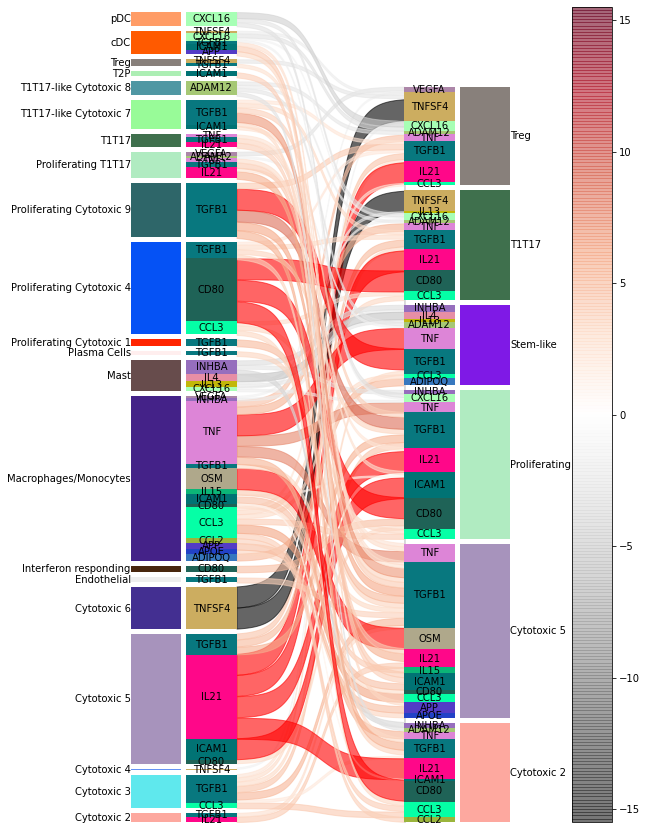

In [189]:
IgG_correct_direction_interactions = gran_clusters_per_gran_ligand_scores[(gran_clusters_per_gran_ligand_scores["p"]<0.05)&gran_clusters_per_gran_ligand_scores["ligand"].isin(cd4_tcells_up_IgG[:25])&(gran_clusters_per_gran_ligand_scores["lfc"]<0)& gran_clusters_per_gran_ligand_scores["receiver"].isin(cd4_exp_cells)]
CD8a_correct_direction_interactions = gran_clusters_per_gran_ligand_scores[(gran_clusters_per_gran_ligand_scores["p"]<0.05)&gran_clusters_per_gran_ligand_scores["ligand"].isin(cd4_tcells_up_CD8a[:25])&(gran_clusters_per_gran_ligand_scores["lfc"]>0)& gran_clusters_per_gran_ligand_scores["receiver"].isin(cd4_exp_cells)]
ligands_reduced = pd.concat([CD8a_correct_direction_interactions,IgG_correct_direction_interactions])
ligands_reduced["0"] = ligands_reduced["lfc"]
rl.plot_rec_ligand_ribbon(ligands_reduced, cell_colors,vmin=vmin,vmax=vmax)
plt.savefig("plots/interaction_plots/new_subsets/CD8a_IgG_granuloma_ligand_CD4_intr_correct_ligands.pdf",bbox_inches="tight")


/data/cb/scratch/nyquist/deeper_sequencing_analysis/receptor_ligand_helpers.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_intr["magnitude"] = np.abs(relevant_intr["0"])


                   sender  ligand             receiver  magnitude
0   Macrophages/Monocytes  ADIPOQ            Stem-like   0.042543
1   Macrophages/Monocytes    APOE          Cytotoxic 5   0.028459
2   Macrophages/Monocytes     APP          Cytotoxic 5   0.039547
3   Macrophages/Monocytes    CCL2          Cytotoxic 2   0.030618
4   Macrophages/Monocytes    CCL3          Cytotoxic 2   0.032054
5   Macrophages/Monocytes    CCL3          Cytotoxic 5   0.051016
6   Macrophages/Monocytes    CCL3  Proliferating T1T17   0.032711
7   Macrophages/Monocytes    CCL3            Stem-like   0.024797
8   Macrophages/Monocytes    CCL3                T1T17   0.027528
9   Macrophages/Monocytes    CCL3                 Treg   0.016542
10  Macrophages/Monocytes    CD80          Cytotoxic 5   0.022918
11  Macrophages/Monocytes   ICAM1          Cytotoxic 2   0.008096
12  Macrophages/Monocytes   ICAM1          Cytotoxic 5   0.038521
13  Macrophages/Monocytes   ICAM1  Proliferating T1T17   0.009287
14  Macrop

/data/cb/scratch/nyquist/deeper_sequencing_analysis/receptor_ligand_helpers.py:369: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdGy_r"))
  cmap.set_under("k")
/data/cb/scratch/nyquist/deeper_sequencing_analysis/receptor_ligand_helpers.py:370: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdGy_r"))
  cmap.set_over("r")


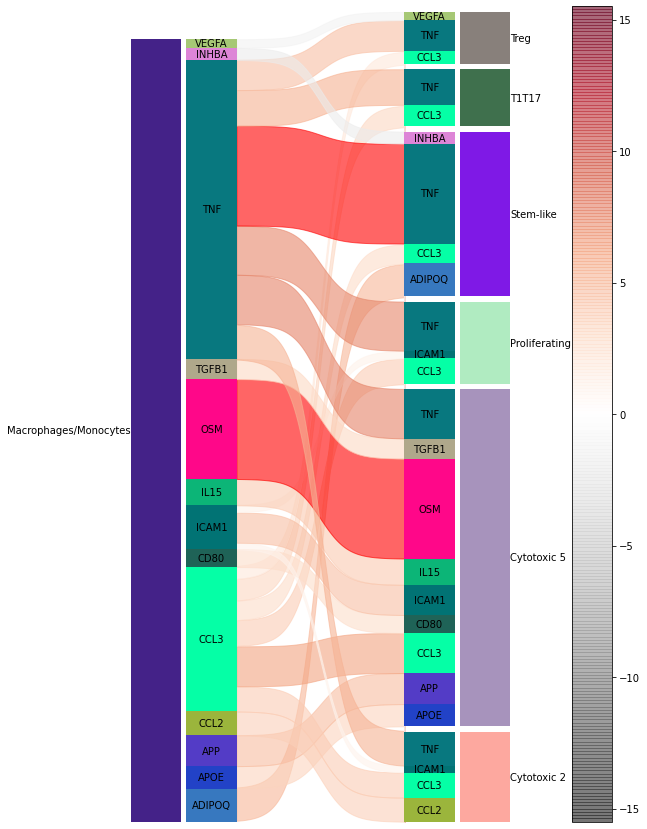

In [191]:
IgG_correct_direction_interactions = gran_clusters_per_gran_ligand_scores[(gran_clusters_per_gran_ligand_scores["p"]<0.05)&gran_clusters_per_gran_ligand_scores["ligand"].isin(cd4_tcells_up_IgG[:25])&(gran_clusters_per_gran_ligand_scores["lfc"]<0)& gran_clusters_per_gran_ligand_scores["receiver"].isin(cd4_exp_cells)]
CD8a_correct_direction_interactions = gran_clusters_per_gran_ligand_scores[(gran_clusters_per_gran_ligand_scores["p"]<0.05)&gran_clusters_per_gran_ligand_scores["ligand"].isin(cd4_tcells_up_CD8a[:25])&(gran_clusters_per_gran_ligand_scores["lfc"]>0)& gran_clusters_per_gran_ligand_scores["receiver"].isin(cd4_exp_cells)]
ligands_reduced = pd.concat([CD8a_correct_direction_interactions,IgG_correct_direction_interactions])
ligands_reduced["0"] = ligands_reduced["lfc"]
mm_sender = ligands_reduced[ligands_reduced["sender"]=="Macrophages/Monocytes"]
rl.plot_rec_ligand_ribbon(mm_sender, cell_colors,vmin=vmin,vmax=vmax)
plt.savefig("plots/interaction_plots/new_subsets/CD8a_IgG_granuloma_ligand_CD4_intr_correct_ligands_justMonomac_senders.pdf",bbox_inches="tight")


In [192]:

ligands_reduced_nop = gran_clusters_per_gran_ligand_scores[gran_clusters_per_gran_ligand_scores["ligand"].isin(ligands_reduced["ligand"].unique()) & gran_clusters_per_gran_ligand_scores["receiver"].isin(cd4_exp_cells)]
ligands_reduced_nop=ligands_reduced_nop[ligands_reduced_nop["sender_receiver"].isin(ligands_reduced["sender_receiver"].unique())]

In [36]:
def boxed_dotplot(ligands_reduced_nop, ligands_reduced, ligand_order=[], receiver_order=[],label_receiver=True):
    if len(ligand_order)==0:
        all_ligands = ligands_reduced_nop["ligand"].unique()
    else:
        all_ligands = ligand_order
    ligand_spacing ={l:(i*.1) for i,l in enumerate(all_ligands)}
    ligands_reduced_nop["ycoord"] = ligands_reduced_nop["ligand"].map(ligand_spacing)
    if len(receiver_order) == 0:
        receiver_order = list(ligands_reduced_nop["receiver"].unique())
    # change order based on receivers 
    tmp=ligands_reduced_nop.groupby(["receiver","sender"]).count().loc[receiver_order].reset_index()
    tmp["index_order"] = [tmp.loc[i,"sender"]+"_to_"+tmp.loc[i,"receiver"] for i in tmp.index]
    l_r_spacing = {lr:(i*.1) for i,lr in enumerate(list(tmp["index_order"]))}
    ligands_reduced_nop["xcoord"] = ligands_reduced_nop["sender_receiver"].map(l_r_spacing)
    ligands_reduced_nop["-logp"] = -1*np.log10(ligands_reduced_nop["p"])
    # dotplot from figure 5A
    ligands_reduced_nop["boxed"]=1
    ligands_reduced_nop.loc[ligands_reduced_nop["p"]<0.05,"boxed"] =0
    figheight=len(all_ligands)*.38
    figwidth=tmp.shape[0]*.4
    plt.figure(figsize=(figwidth,figheight))
    cmap = plt.cm.RdGy_r
    cmap.set_under("k")
    cmap.set_over("r")
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    kwargs_box = {'edgecolor':"k","linewidth":1,"linestyle":"-"}
    ax=sns.scatterplot(data=ligands_reduced_nop, x= "xcoord",y="ycoord",size="boxed",sizes=(0, 350),color="w",marker="s",**kwargs_box)
    kwargs  =   {'edgecolor':"k", # for edge color
                 'linewidth':0, # line width of spot
                 'linestyle':'-', # line style of spot
                }
    sns.scatterplot(data=ligands_reduced_nop, x= "xcoord",y="ycoord",hue="lfc",size="-logp",palette="RdGy_r",sizes=(0, 350),hue_norm=(-15,15),ax=ax,**kwargs)
    plt.yticks(list(ligand_spacing.values()),list(ligand_spacing.keys()))
    if not label_receiver:
        plt.xticks(list(l_r_spacing.values()),list([i.split("_to")[0] for i in l_r_spacing.keys()]),rotation=90)
    else:
        plt.xticks(list(l_r_spacing.values()),list( l_r_spacing.keys()),rotation=90)

In [301]:
#ligands_reduced_nop.groupby(["receiver","sender"]).count().loc[["Cytotoxic 2","Cytotoxic 5"]]

In [38]:
new_adata.raw=new_adata

In [196]:
cluster_subs_rev = {}
for c,l in cluster_subs.items():
    for s in l:
        cluster_subs_rev[s] = c

new_adata.obs["cluster_subs"] = new_adata.obs["sample"].map(cluster_subs_rev)    

In [197]:
sub_new_adata = new_adata[new_adata.obs["cluster_subs"].notna()]

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


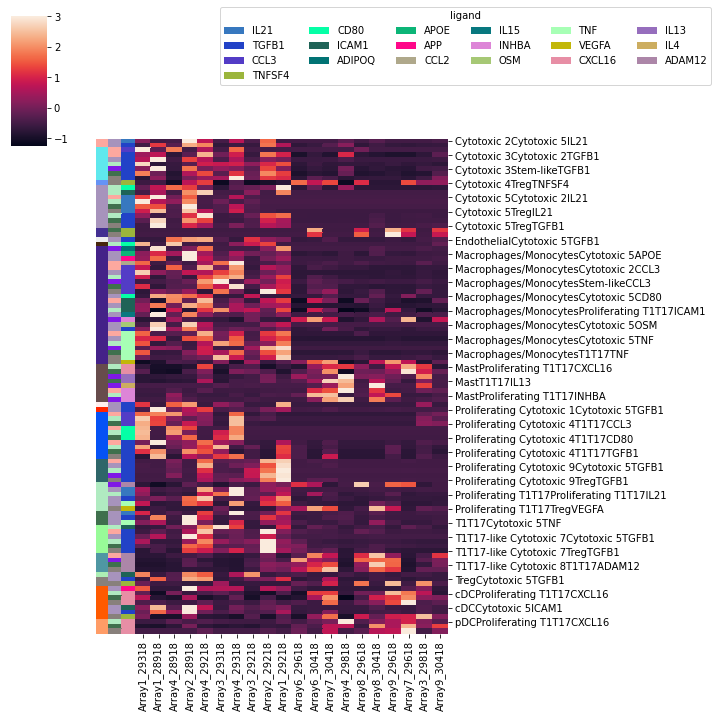

In [40]:
# sender ordered heatmap
from matplotlib.patches import Patch
arrays_of_interest = cluster_subs["CD8a_sub"]+cluster_subs["IgG_sub"]
tmp=ligands_reduced.groupby(["sender","ligand","receiver"]).count().reset_index()
tmp["index_order"] = tmp["sender"]+tmp["receiver"]+tmp["ligand"]
ligand_colors = dict(zip(tmp["ligand"].unique(), list(mcolors.XKCD_COLORS.values())[20:20+len(tmp["ligand"].unique())]))

tmp["sender_color"]= tmp["sender"].map(cell_colors)
tmp["receiver_color"]=tmp["receiver"].map(cell_colors)
tmp["ligand_color"]=tmp["ligand"].map(ligand_colors)
handles = [Patch(facecolor=ligand_colors[name]) for name in ligand_colors]

sns.clustermap(ligands_reduced.loc[tmp["index_order"],arrays_of_interest],z_score=0,col_cluster=False,row_cluster=False,vmax=3,row_colors=[tmp["sender_color"],tmp["receiver_color"],tmp["ligand_color"]])

plt.legend(handles, ligand_colors, title='ligand',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right',ncol=6)

plt.savefig("plots/interaction_plots/new_subsets/cd4_sender_ordered_heatmap.pdf",bbox_inches="tight")

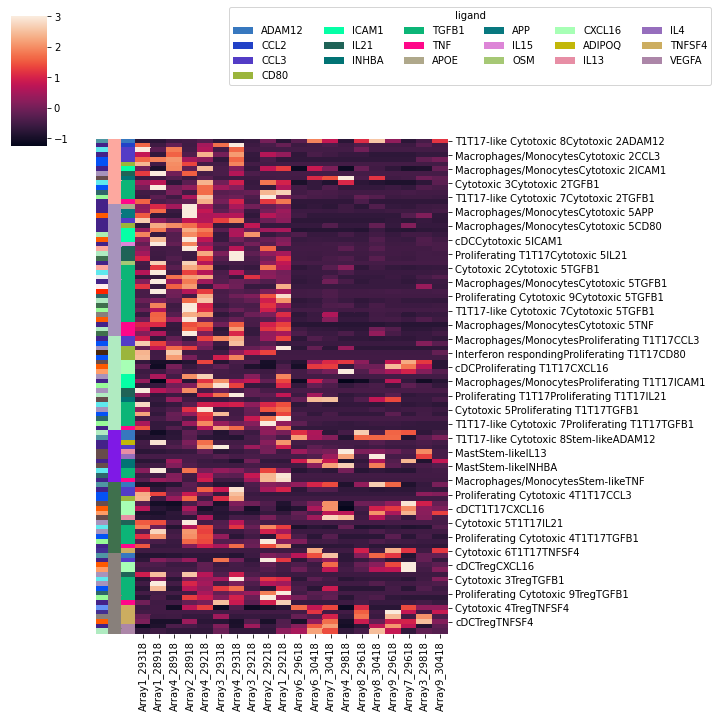

In [41]:
# receiver ordered heatmap
tmp=ligands_reduced.groupby(["receiver","ligand","sender"]).count().reset_index()
tmp["index_order"] = tmp["sender"]+tmp["receiver"]+tmp["ligand"]
ligand_colors = dict(zip(tmp["ligand"].unique(), list(mcolors.XKCD_COLORS.values())[20:20+len(tmp["ligand"].unique())]))

tmp["sender_color"]= tmp["sender"].map(cell_colors)
tmp["receiver_color"]=tmp["receiver"].map(cell_colors)
tmp["ligand_color"]=tmp["ligand"].map(ligand_colors)


handles = [Patch(facecolor=ligand_colors[name]) for name in ligand_colors]

sns.clustermap(ligands_reduced.loc[tmp["index_order"],arrays_of_interest],z_score=0,col_cluster=False,row_cluster=False,vmax=3,row_colors=[tmp["sender_color"],tmp["receiver_color"],tmp["ligand_color"]])
plt.legend(handles, ligand_colors, title='ligand',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right',ncol=6)

plt.savefig("plots/interaction_plots/new_subsets/cd4_receiver_ordered_heatmap.pdf",bbox_inches="tight")

In [216]:
# make ligand annotations dataframe
ligand_annotations = pd.DataFrame(columns=["Ligand","Cluster Direction","Significantly Changing Interactions","Significant Receivers","Niche-net Ligand Targets","Potetial Receptors"])
ligand_annotations["Ligand"] = cd4_tcells_up_CD8a+cd4_tcells_up_IgG
ligand_annotations["Cluster Direction"] = (["CD8a"]*len(cd4_tcells_up_CD8a)) + (["IgG"]*len(cd4_tcells_up_IgG))
ligand_grouped = ligands_reduced.groupby("ligand")
for l,g in ligand_grouped:
    ligand_annotations.loc[ligand_annotations["Ligand"]==l,"Significantly Changing Interactions"]=", ".join(list(g["sender_receiver"].unique()))
    ligand_annotations.loc[ligand_annotations["Ligand"]==l,"Significant Receivers"]=", ".join(list(g["receiver"].unique()))


In [217]:
#read in target links from nichenet
ligand_target_links = pd.read_csv("RL_input_data/active_ligand_target_links_cluster_subbed_CD8avIgG_cd4.csv")
ligand_target_links2 = pd.read_csv("RL_input_data/active_ligand_target_links_cluster_subbed_IgGvCD8a_cd4.csv")
ligand_target_links_all = pd.concat([ligand_target_links,ligand_target_links2])


In [219]:
# add ligand target links to ligand annotatons
for l in ligand_annotations["Ligand"]:
    lig_targets = ligand_target_links_all[ligand_target_links_all["ligand"]==l]
    ligand_annotations.loc[ligand_annotations["Ligand"]==l,"Niche-net Ligand Targets"] = ", ".join(list(lig_targets["target"].unique()))
    
for l in ligand_annotations["Ligand"]:
    lig_receptors = receptor_ligand_list[receptor_ligand_list["Ligand"]==l]
    ligand_annotations.loc[ligand_annotations["Ligand"]==l,"Potetial Receptors"] = ", ".join(list(lig_receptors["Receptor"].unique()))
    
    

In [220]:
ligand_annotations.to_csv("plots/interaction_plots/new_subsets/cd4_ligand_annotations.csv")

In [47]:
# score on targets

for i,r in ligand_annotations.iterrows():
    if type(r["Significantly Changing Interactions"])==str:
        
        targets = r["Niche-net Ligand Targets"].split(", ")
        if len(targets) > 1: #r["Ligand"]+" target score" not in new_adata.obs.columns and 
            print(r["Ligand"])
            sc.tl.score_genes(new_adata, targets, score_name=r["Ligand"]+" target score")
        

TNF
IL13
APOE
ICAM1
IL4
CCL2
TGFB1
OSM
CD80
IL21
IL15
ADIPOQ
CCL3
IL4
IL13
CXCL16
INHBA
TNFSF4
ADAM12
VEGFA


In [213]:
scorenames = [i+" target score" for i in ligands_reduced["ligand"].unique()]

In [214]:
scorenames.remove("APP target score") # APP has no targets

In [231]:
scorenames_order_MM = ["IL15 target score","TGFB1 target score","TNF target score","OSM target score",
                    "CCL3 target score","CCL2 target score",
                   "ICAM1 target score",
                    'CD80 target score','APOE target score','ADIPOQ target score',
                   "VEGFA target score","CXCL16 target score",
                   "INHBA target score"]


/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

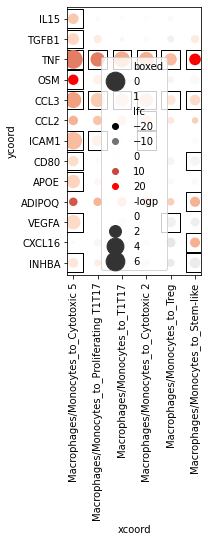

In [237]:
## FIGURE 8A 
#Note, this was run on a previous naming of cell clusters where we called cytotoxic cluster 6 cytotoxic cluster 5. 
# this naming was changed to make moonlighting clusters vs control clusters easier to read
boxed_dotplot(ligands_reduced_nop[ligands_reduced_nop["sender"]=="Macrophages/Monocytes"], ligands_reduced,ligand_order = [i.split(" ")[0] for i in reversed(scorenames_order_MM)],receiver_order=["Cytotoxic 5","Proliferating T1T17","T1T17","Cytotoxic 2", "Treg","Stem-like"])
plt.savefig("plots/interaction_plots/new_subsets/cd4_rl_lfc_dotplot_mmsender.pdf",bbox_inches="tight")


# gd_cells

In [288]:
gd_exp_cells=["Non-cytotoxic CD8","Cytotoxic 3","Cytotoxic 4","Proliferating Cytotoxic 9","T1T17-like Cytotoxic 7"]

gd_up_cd8a_nichenet = ['HMGB2','TGFB1','IL21','GDF6','IL13','CSF2','AGT','CRLF1','IL2','CD28','CLCF1','GDF2','CCL3','IL12A','IL15','IL12B','IL22','TNFSF18','CD80','IL27','TNFSF14','IFNK','ITGA4','CCL11','CCL26','IL9','CCL8','ICAM1','IBSP','IFNL1']
gd_up_igg_nichenet = ['PROK1','CRH','TGFB1','EDN1','PTH','CCL20','GDF2','OCLN','XCL1','EDN2','GRP','CCL25','SEMA4D','NPFF','WNT4','QRFP','GIP','NMB','TAC3','NRXN1','NPS','PROK2','PDYN','CCL28','UTS2B','CCL13','CXCL11','NMS','VWF','NMU']


                    sender ligand                   receiver  magnitude
0              Cytotoxic 1  TGFB1                Cytotoxic 4   0.011241
1              Cytotoxic 2   IL21     T1T17-like Cytotoxic 7   0.011152
2              Cytotoxic 3  TGFB1                Cytotoxic 3   0.011445
3              Cytotoxic 3  TGFB1                Cytotoxic 4   0.005390
4              Cytotoxic 3  TGFB1  Proliferating Cytotoxic 9   0.017344
..                     ...    ...                        ...        ...
61  T1T17-like Cytotoxic 8   IL21                Cytotoxic 3   0.013121
62  T1T17-like Cytotoxic 8  TGFB1                Cytotoxic 4   0.007308
63  T1T17-like Cytotoxic 8  TGFB1          Non-cytotoxic CD8   0.009031
64                    Treg  TGFB1                Cytotoxic 4   0.008099
65                     pDC  TGFB1                Cytotoxic 4   0.010633

[66 rows x 4 columns]


/data/cb/scratch/nyquist/deeper_sequencing_analysis/receptor_ligand_helpers.py:369: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdGy_r"))
  cmap.set_under("k")
/data/cb/scratch/nyquist/deeper_sequencing_analysis/receptor_ligand_helpers.py:370: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdGy_r"))
  cmap.set_over("r")


                                                              sender  \
Cytotoxic 1Cytotoxic 4TGFB1                              Cytotoxic 1   
Cytotoxic 2T1T17-like Cytotoxic 7IL21                    Cytotoxic 2   
Cytotoxic 3Cytotoxic 3TGFB1                              Cytotoxic 3   
Cytotoxic 3Cytotoxic 4TGFB1                              Cytotoxic 3   
Cytotoxic 3Proliferating Cytotoxic 9TGFB1                Cytotoxic 3   
...                                                              ...   
T1T17-like Cytotoxic 8Cytotoxic 3IL21         T1T17-like Cytotoxic 8   
T1T17-like Cytotoxic 8Cytotoxic 4TGFB1        T1T17-like Cytotoxic 8   
T1T17-like Cytotoxic 8Non-cytotoxic CD8TGFB1  T1T17-like Cytotoxic 8   
TregCytotoxic 4TGFB1                                            Treg   
pDCCytotoxic 4TGFB1                                              pDC   

                                                               receiver  \
Cytotoxic 1Cytotoxic 4TGFB1                                 

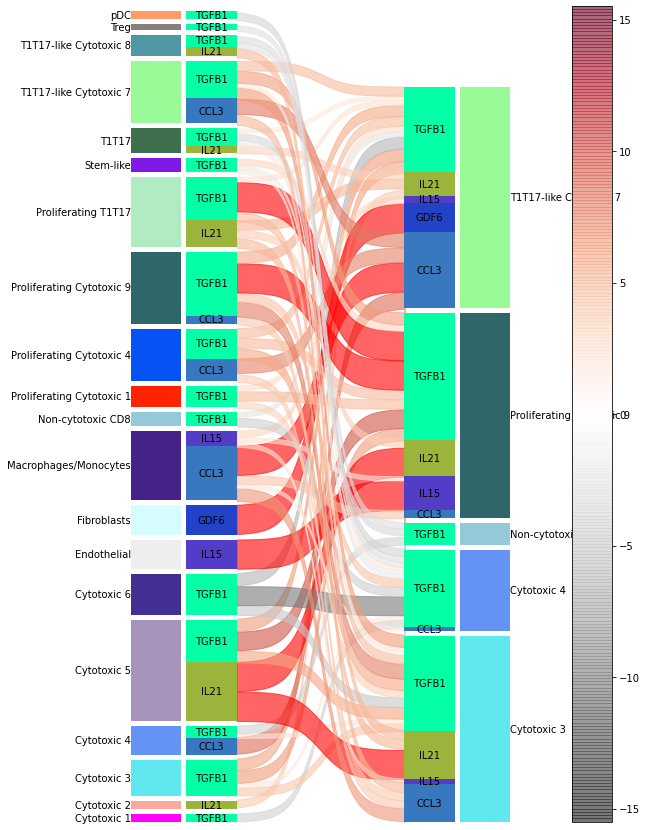

In [289]:
igg_correct_direction_interactions = gran_clusters_per_gran_ligand_scores[(gran_clusters_per_gran_ligand_scores["p"]<0.05)&gran_clusters_per_gran_ligand_scores["ligand"].isin(gd_up_igg_nichenet[:25])&(gran_clusters_per_gran_ligand_scores["lfc"]<0)& gran_clusters_per_gran_ligand_scores["receiver"].isin(gd_exp_cells)]
cd8a_correct_direction_interactions = gran_clusters_per_gran_ligand_scores[(gran_clusters_per_gran_ligand_scores["p"]<0.05)&gran_clusters_per_gran_ligand_scores["ligand"].isin(gd_up_cd8a_nichenet[:25])&(gran_clusters_per_gran_ligand_scores["lfc"]>0)& gran_clusters_per_gran_ligand_scores["receiver"].isin(gd_exp_cells)]
ligands_reduced = pd.concat([cd8a_correct_direction_interactions,igg_correct_direction_interactions])
ligands_reduced["0"] = ligands_reduced["lfc"]
rl.plot_rec_ligand_ribbon(ligands_reduced, cell_colors,vmin=vmin,vmax=vmax)
plt.savefig("plots/interaction_plots/new_subsets/CD8a_IgG_granuloma_ligand_gd_intr_correct_ligands.pdf",bbox_inches="tight")



In [290]:
ligand_annotations = pd.DataFrame(columns=["Ligand","Cluster Direction","Significantly Changing Interactions","Significant Receivers","Niche-net Ligand Targets","Potetial Receptors"])
ligand_annotations["Ligand"] = gd_up_cd8a_nichenet+gd_up_igg_nichenet
ligand_annotations["Cluster Direction"] = (["CD8a"]*len(gd_up_cd8a_nichenet)) + (["IgG"]*len(gd_up_igg_nichenet))
ligand_grouped = ligands_reduced.groupby("ligand")
for l,g in ligand_grouped:
    ligand_annotations.loc[ligand_annotations["Ligand"]==l,"Significantly Changing Interactions"]=", ".join(list(g["sender_receiver"].unique()))
    ligand_annotations.loc[ligand_annotations["Ligand"]==l,"Significant Receivers"]=", ".join(list(g["receiver"].unique()))

In [292]:
ligand_target_links = pd.read_csv("RL_input_data/active_ligand_target_links_cluster_subbed_CD8avIgG_gd.csv")
ligand_target_links2 = pd.read_csv("RL_input_data/active_ligand_target_links_cluster_subbed_IgGvCD8a_gd.csv")
ligand_target_links_all = pd.concat([ligand_target_links,ligand_target_links2])

In [293]:
for l in ligand_annotations["Ligand"]:
    lig_targets = ligand_target_links_all[ligand_target_links_all["ligand"]==l]
    ligand_annotations.loc[ligand_annotations["Ligand"]==l,"Niche-net Ligand Targets"] = ", ".join(list(lig_targets["target"].unique()))

In [294]:
for l in ligand_annotations["Ligand"]:
    lig_receptors = receptor_ligand_list[receptor_ligand_list["Ligand"]==l]
    ligand_annotations.loc[ligand_annotations["Ligand"]==l,"Potetial Receptors"] = ", ".join(list(lig_receptors["Receptor"].unique()))
    
    

In [295]:
ligand_annotations.to_csv("plots/interaction_plots/new_subsets/gd_ligand_annotations.csv")

In [70]:
for i,r in ligand_annotations.iterrows():
    if type(r["Significantly Changing Interactions"])==str:
        receivers = r["Significant Receivers"].split(", ")
        receptors = r["Potetial Receptors"].split(", ")
        targets = r["Niche-net Ligand Targets"].split(", ")
        sc.pl.dotplot(new_adata[new_adata.obs["Subclusters_t"].isin(receivers)], {"receptors":receptors,"targets":targets},groupby="Subclusters_t")
        plt.title(r["Ligand"])

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.


KeyboardInterrupt: 

In [ ]:
intr_subs = ligand_annotations.loc[ligand_annotations["Significantly Changing Interactions"].notna(),["Ligand","Cluster Direction","Significantly Changing Interactions"]]
for i in intr_subs.index:
    print(intr_subs.loc[i,"Ligand"])
    print(intr_subs.loc[i,"Cluster Direction"])
    print(intr_subs.loc[i,"Significantly Changing Interactions"])

In [300]:
# score on targets

for i,r in ligand_annotations.iterrows():
    if type(r["Significantly Changing Interactions"])==str:
        
        targets = r["Niche-net Ligand Targets"].split(", ")
        if r["Ligand"]+" gd target score" not in sub_new_adata.obs.columns and len(targets) > 1:
            print(targets)
            sc.tl.score_genes(sub_new_adata, targets, score_name=r["Ligand"]+" gd target score")
        



['ACTB', 'GLRX', 'GZMB', 'ITGA4', 'ITGAM', 'ITGAX', 'OAS1', 'PDGFD', 'PDGFRB', 'PRF1', 'S100A9', 'SERPINA1', 'AHR', 'COX1', 'ICAM2', 'ITGA1', 'JUNB', 'LPIN1', 'NR3C1', 'RARA', 'RPL27', 'SOCS3', 'TNFSF10', 'TNFSF13B']
['GZMB', 'NKG7', 'PLEK']
['FLNA', 'GSN', 'MAPK1', 'S100A10', 'ZEB2']
['ACTB', 'BRCA1', 'CLEC12A', 'CLIC1', 'CSRP1', 'ESRRA', 'GSN', 'PFN1', 'RGS3', 'SERPINA1', 'WEE1']
['GZMB', 'LRMP', 'PRF1', 'RGS3', 'SLAMF7']


In [301]:
scorenames = [i+" gd target score" for i in ligands_reduced["ligand"].unique()]

In [302]:
scorenames

['CCL3 gd target score',
 'GDF6 gd target score',
 'IL15 gd target score',
 'IL21 gd target score',
 'TGFB1 gd target score']

In [303]:
scorenames_order = ["APP target score","IFNG target score","CCL3 target score","IL18 target score","IL15 target score","IL21 target score",
                   "IL27 target score","EBI3 target score","GDF6 target score","IL22 target score",
                   "TNF target score","TSLP target score","TGFB1 target score","GDF7 target score","INHBA target score",
                   "LTA target score","VEGFA target score"]
categories_order = ["Proliferating Cytotoxic 9","T1T17-like Cytotoxic 7","Cytotoxic 4","Cytotoxic 3","Non-cytotoxic CD8"]
print(len(scorenames))
print(len(scorenames_order))

5
17


/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'cluster_subs' as categorical


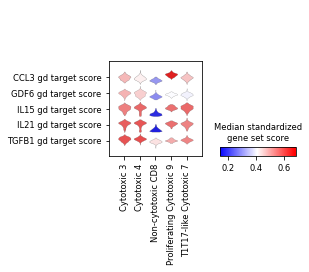

In [304]:
sc.pl.stacked_violin(sub_new_adata[sub_new_adata.obs["Subclusters_t"].isin(gd_exp_cells)], scorenames, groupby="Subclusters", swap_axes=True,cmap="bwr",standard_scale="var",
                   dendrogram=False,show=False,colorbar_title="Median standardized\ngene set score")
plt.savefig("plots/interaction_plots/new_subsets/gd_cells_ligand_target_scores.pdf",bbox_inches="tight")


In [305]:
ligands_reduced_nop = gran_clusters_per_gran_ligand_scores[gran_clusters_per_gran_ligand_scores["ligand"].isin(ligands_reduced["ligand"].unique()) & gran_clusters_per_gran_ligand_scores["receiver"].isin(gd_exp_cells)]
ligands_reduced_nop=ligands_reduced_nop[ligands_reduced_nop["sender_receiver"].isin(ligands_reduced["sender_receiver"].unique())]


/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdGy_r"))
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdGy_r"))


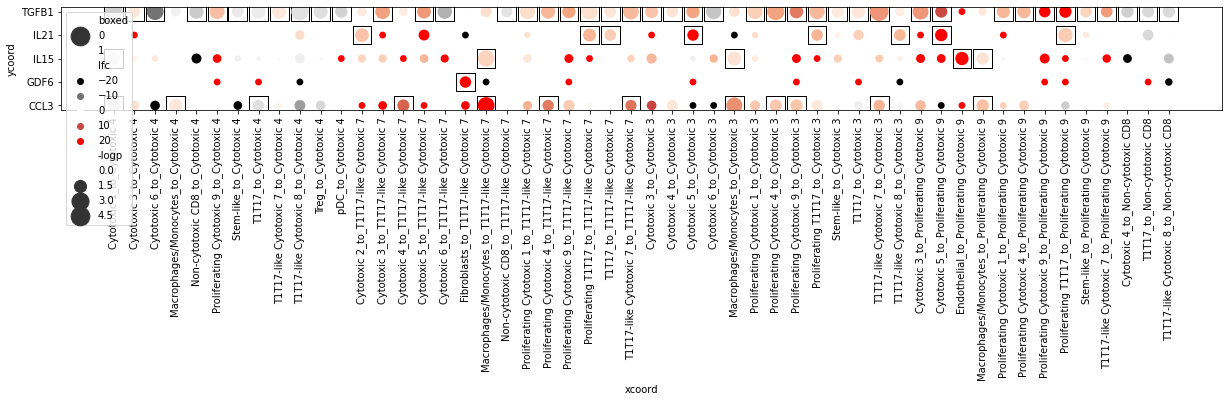

In [306]:
boxed_dotplot(ligands_reduced_nop, ligands_reduced)


plt.savefig("plots/interaction_plots/new_subsets/gd_rl_lfc_dotplot.pdf",bbox_inches="tight")

/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/afs/csail.mit.edu/u/n/nyquist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

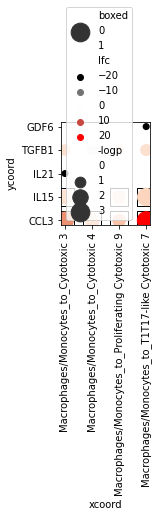

In [308]:
#Figure 8B, cluster names were renumbered here too, cluster 4 and 3 are swapped, cytotoxic 7 is cytotoxic 8, 
#proliferating 9 is proliferating 8
# in formatting the final figure, we removed the ligands with no significan interaction logfold change
boxed_dotplot(ligands_reduced_nop[ligands_reduced_nop["sender"]=="Macrophages/Monocytes"], ligands_reduced)


plt.savefig("plots/interaction_plots/new_subsets/gd_rl_lfc_dotplot_from_mm.pdf",bbox_inches="tight")

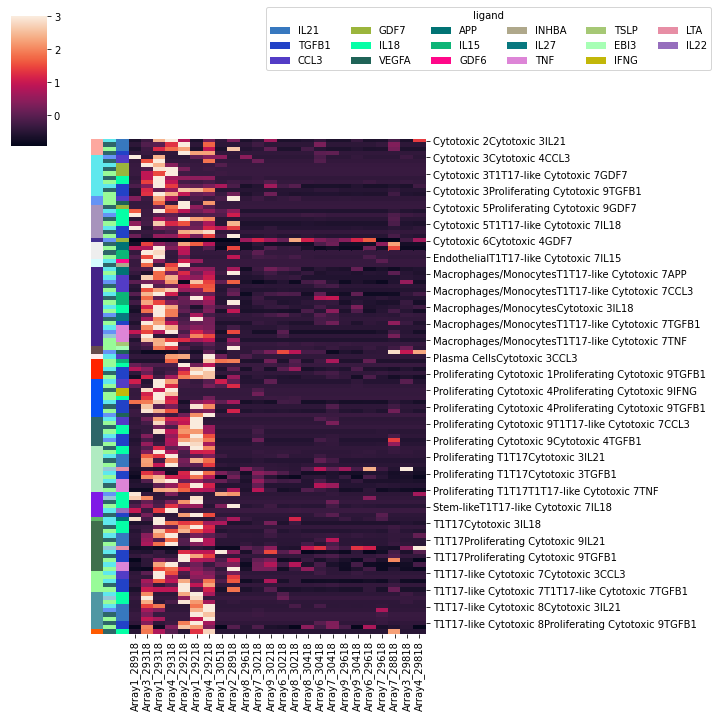

In [170]:
# if this doesnt work because of an indexerror in ligands_reduced, run ribbonplot first
arrays_of_interest = clusters["Cluster 2"]+clusters["Cluster 4"]
tmp=ligands_reduced.groupby(["sender","ligand","receiver"]).count().reset_index()
tmp["index_order"] = tmp["sender"]+tmp["receiver"]+tmp["ligand"]
ligand_colors = dict(zip(tmp["ligand"].unique(), list(mcolors.XKCD_COLORS.values())[20:20+len(tmp["ligand"].unique())]))

tmp["sender_color"]= tmp["sender"].map(cell_colors)
tmp["receiver_color"]=tmp["receiver"].map(cell_colors)
tmp["ligand_color"]=tmp["ligand"].map(ligand_colors)
handles = [Patch(facecolor=ligand_colors[name]) for name in ligand_colors]

sns.clustermap(ligands_reduced.loc[tmp["index_order"],arrays_of_interest],z_score=0,col_cluster=False,row_cluster=False,vmax=3,row_colors=[tmp["sender_color"],tmp["receiver_color"],tmp["ligand_color"]])

plt.legend(handles, ligand_colors, title='ligand',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right',ncol=6)

#plt.savefig("plots/interaction_plots/gd_sender_ordered_heatmap.pdf",bbox_inches="tight")

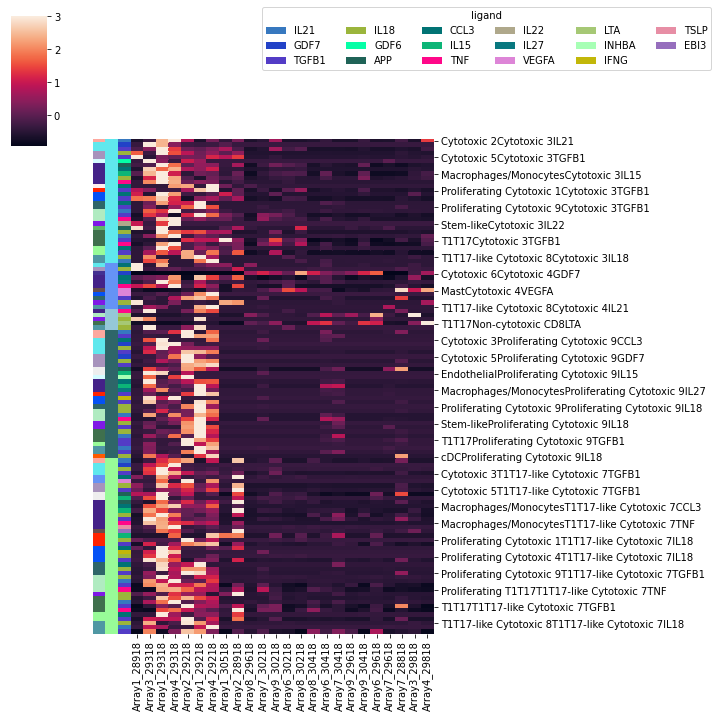

In [171]:
tmp=ligands_reduced.groupby(["receiver","sender","ligand"]).count().reset_index()
tmp["index_order"] = tmp["sender"]+tmp["receiver"]+tmp["ligand"]
ligand_colors = dict(zip(tmp["ligand"].unique(), list(mcolors.XKCD_COLORS.values())[20:20+len(tmp["ligand"].unique())]))

tmp["sender_color"]= tmp["sender"].map(cell_colors)
tmp["receiver_color"]=tmp["receiver"].map(cell_colors)
tmp["ligand_color"]=tmp["ligand"].map(ligand_colors)
handles = [Patch(facecolor=ligand_colors[name]) for name in ligand_colors]

sns.clustermap(ligands_reduced.loc[tmp["index_order"],arrays_of_interest],z_score=0,col_cluster=False,row_cluster=False,vmax=3,row_colors=[tmp["sender_color"],tmp["receiver_color"],tmp["ligand_color"]])

plt.legend(handles, ligand_colors, title='ligand',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right',ncol=6)

#plt.savefig("plots/interaction_plots/gd_reveiver_ordered_heatmap.pdf",bbox_inches="tight")